# Исследование тарифов телеком-компании

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Нам предстоит выполнение следующих **задач**:
- Изучить данные из нескольких датасетов;
- При необходимости исправить ошибки данных, изучить выбросы;
- Объединить все доступные данные по пользователям, которые разделены по датасетам, проверить, нет ли потерь при объединении, заполнить пропуски данных;
- Проанализировать поведение пользователей 2-х тарифов, определить, какой тариф выгоднее для оператора (и с т.зр. выручки, и с т.зр. роста количества пользователей и увеличения их активности.)
- Проверить гипотезы о сходстве/различии средних выручки 2-х тарифов, а также от сходстве/различии средних выручек московских и региональных пользователей;
- Сформулировать общие выводы, а также идеи, которые позволят бизнесу принять решения о развитии тарифной политики;

**Использованные данные**:

Таблица users (информация о пользователях):

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


## Изучение данных из файла

Импортируем датасеты с данными о поведении пользователей 2-х тарифов телеком-компании.

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import seaborn as sns

In [170]:
try:
    df_calls = pd.read_csv('calls.csv')
    df_internet = pd.read_csv('internet.csv', index_col=0)
    df_messages = pd.read_csv('messages.csv')
    df_tariffs = pd.read_csv('tariffs.csv')
    df_users = pd.read_csv('users.csv')
except:
    df_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
    df_calls = pd.read_csv('/datasets/calls.csv')
    df_messages = pd.read_csv('/datasets/messages.csv')
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')
    df_users = pd.read_csv('/datasets/users.csv')

In [171]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [172]:
print('Количество уникальных пользователей:', len(df_calls['user_id'].unique()))

Количество уникальных пользователей: 492


In [173]:
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [174]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [175]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [176]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Text(0.5, 0, 'Трафик, мегабайты')

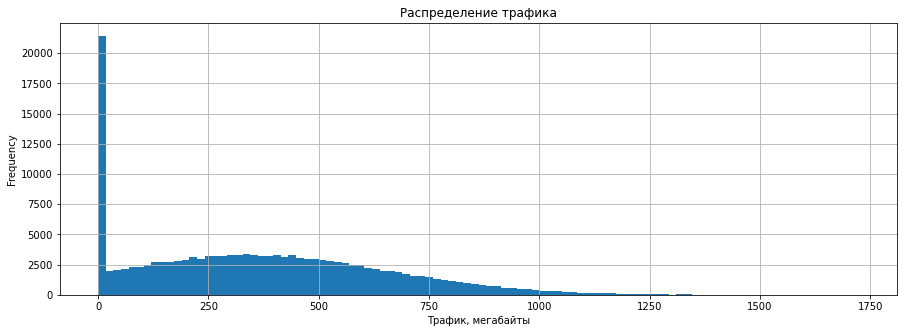

In [177]:
df_internet['mb_used'].plot(kind='hist', bins=100, grid=True, figsize=(15, 5)).set_title('Распределение трафика')
plt.xlabel("Трафик, мегабайты")

На гистограмме мы видим скачок в значении "0 мб". Клиенты пытались зайти в интернет, но происходит обрыв связи, и это явно предмет для разговора с техническим отделом. Если это будет важно для бизнеса, то необходимо будет посмотреть, в каком городе, когда, и у каких уникальных юзеров это произошло. 

Посчитаем количество сессий с обрывом связи

In [178]:
df_internet[df_internet['mb_used'] == 0.0].count()

id              19598
mb_used         19598
session_date    19598
user_id         19598
dtype: int64

Посмотрим на распределение трафика после исключений сессий с обрывом связи

Text(0.5, 0, 'Трафик, мегабайты')

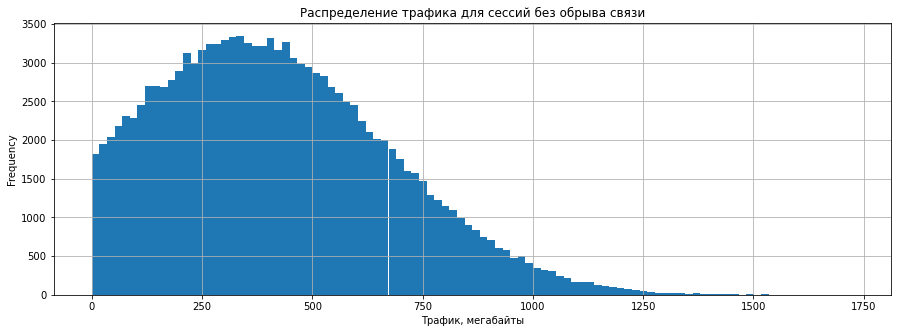

In [179]:
df_internet[df_internet['mb_used'] > 0.0]['mb_used']\
    .plot(kind='hist', bins=100, grid=True, figsize=(15, 5))\
    .set_title('Распределение трафика для сессий без обрыва связи')
plt.xlabel("Трафик, мегабайты")

Посчитаем количество дублей

In [180]:
print(df_calls.duplicated().sum())
print(df_messages.duplicated().sum())
print(df_internet.duplicated().sum())
print(df_users.duplicated().sum())

0
0
0
0


**Выводы** по дополнительным пунктам:
- среди всех интернет-сессий есть ок 13% (19958) случаев, когда пользователи не пользовались интернетом, если быть точнее - сессии с нулевым трафиком;
- распределение интернет сессий похоже на нормальное со скошенностью влево и выбросами в правой части. Медиана приходится на 560 мб, а максимальные значения достигают 1750 мб. 
- Дубликатов во всех 4-х датасетах не найдено;

## Предобработка данных

Анализ данных, исправление ошибок, приведение к нужному типу данных

In [181]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [182]:
df_calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [183]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [184]:
df_internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


In [185]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [186]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [187]:
df_users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Датасет со **звонками** - переводим данные с датой в **формат даты**, а также **округляем** длительность звонка до минут и переводим его в целочисленный тип.

In [188]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')

In [189]:
df_calls['duration'] = df_calls['duration'].apply(np.ceil)
df_calls['duration'] = df_calls['duration'].astype(int)

Датасет с **интернет-соединениями**: переведем данные с датой в формат даты.

In [190]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')

Датасет с **сообщениями** - перевод нужных данных в формат даты.

In [191]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')

Датасет с **пользователями** - переведем данные столбцов даты подключения тарифа и даты прекращения пользования тарифом в формат даты.

In [192]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

In [193]:
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

Датасет с **тарифами** - добавим столбец с гигабайтами.

In [194]:
df_tariffs['gb_per_month_included'] = df_tariffs['mb_per_month_included'] / 1024
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


**Выводы**:
- в основном была необходимость поменять формат некоторых данных, как правило - перевод в формат даты.
- во всех датасетах нет пропусков (за исключением данны о дате окончания использования тарифа). Однако, количество пользователей в датасетах разное, видимо, часть услуг остались невостребованными в течение года. 
- отметим, что неявных дублей или ошибок в названии населенных пунктов или тарифов не было обнаружено (через проверку уникальных значений в нужных столбцах.)

Посчитаем **количество** сделанных **звонков** и израсходованных **минут** разговора по месяцам.

In [195]:
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int32         
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(2), object(1)
memory usage: 7.0+ MB


In [196]:
df_calls_duration = df_calls.groupby(['user_id', 'month'])['duration'].sum()
df_calls_duration = df_calls_duration.reset_index()
df_calls_duration = df_calls_duration.rename(columns={'duration':'calls_duration'})
df_calls_duration.head()

,user_id,month,calls_duration
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466


In [197]:
df_calls_quantity = df_calls.groupby(['user_id', 'month'])['duration'].count() 
df_calls_quantity = df_calls_quantity.reset_index()
df_calls_quantity = df_calls_quantity.rename(columns={'duration':'calls_quantity'})
df_calls_quantity.head()

,user_id,month,calls_quantity
0,1000,5,22
1,1000,6,43
2,1000,7,47
3,1000,8,52
4,1000,9,58


Посчитаем **количество** отправленных **сообщений** по месяцам.

In [198]:
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month

In [199]:
df_messages_groupby = df_messages.groupby(['user_id', 'month'])['id'].count() 
df_messages_groupby = df_messages_groupby.reset_index()
df_messages_groupby = df_messages_groupby.rename(columns={'id':'sms_quantity'})
df_messages_groupby.head()

,user_id,month,sms_quantity
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Посчитаем **объем** израсходованного интернет-трафика по месяцам, **переведем** траффик в гигабайты с **округлением** в большую сторону.

In [200]:
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month

In [201]:
df_internet_groupby = df_internet.groupby(['user_id', 'month'])['mb_used'].sum() 
df_internet_groupby = df_internet_groupby.reset_index()
df_internet_groupby['gb_used'] = df_internet_groupby['mb_used'] / 1024
df_internet_groupby['gb_used'] = np.ceil(df_internet_groupby['gb_used'])
df_internet_groupby.head()

,user_id,month,mb_used,gb_used
0,1000,5,2253.49,3.0
1,1000,6,23233.77,23.0
2,1000,7,14003.64,14.0
3,1000,8,14055.93,14.0
4,1000,9,14568.91,15.0


**Объединим** все датасеты с данными по пользователям.

In [202]:
df_users_pivot = df_calls_duration.merge(df_calls_quantity, on=['user_id','month'], how='outer')
df_users_pivot = df_users_pivot.merge(df_messages_groupby, on=['user_id','month'], how='outer')
df_users_pivot = df_users_pivot.merge(df_internet_groupby, on=['user_id','month'], how='outer')
df_users_pivot = df_users_pivot.merge(df_users, on='user_id', how='outer')
df_users_pivot = df_users_pivot.rename(columns={'tariff':'tariff_name'})
df_users_pivot = df_users_pivot.merge(df_tariffs, on='tariff_name', how='outer')
df_users_pivot = df_users_pivot.sort_values(by='user_id')

df_users_pivot

,user_id,month,calls_duration,calls_quantity,sms_quantity,mb_used,gb_used,age,churn_date,city,...,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204,1498,9.0,471.0,59.0,44.0,22134.41,22.0,68,2018-10-25,Владикавказ,...,2018-07-19,smart,50,15360,500,550,200,3,3,15.0
3206,1499,9.0,70.0,9.0,11.0,1845.75,2.0,35,NaT,Пермь,...,2018-09-27,smart,50,15360,500,550,200,3,3,15.0
3207,1499,10.0,449.0,68.0,48.0,17788.51,18.0,35,NaT,Пермь,...,2018-09-27,smart,50,15360,500,550,200,3,3,15.0
3208,1499,11.0,612.0,74.0,59.0,17963.31,18.0,35,NaT,Пермь,...,2018-09-27,smart,50,15360,500,550,200,3,3,15.0


In [203]:
print(df_users_pivot.duplicated().sum())

0


In [204]:
df_users_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3209
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3214 non-null   float64       
 2   calls_duration         3174 non-null   float64       
 3   calls_quantity         3174 non-null   float64       
 4   sms_quantity           2717 non-null   float64       
 5   mb_used                3203 non-null   float64       
 6   gb_used                3203 non-null   float64       
 7   age                    3216 non-null   int64         
 8   churn_date             189 non-null    datetime64[ns]
 9   city                   3216 non-null   object        
 10  first_name             3216 non-null   object        
 11  last_name              3216 non-null   object        
 12  reg_date               3216 non-null   datetime64[ns]
 13  tar

Заполним пропуски данных

In [205]:
df_users_pivot['calls_duration'] = df_users_pivot['calls_duration'].fillna(0)
df_users_pivot['calls_quantity'] = df_users_pivot['calls_quantity'].fillna(0)
df_users_pivot['sms_quantity'] = df_users_pivot['sms_quantity'].fillna(0)
df_users_pivot['gb_used'] = df_users_pivot['gb_used'].fillna(0)
df_users_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3209
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3214 non-null   float64       
 2   calls_duration         3216 non-null   float64       
 3   calls_quantity         3216 non-null   float64       
 4   sms_quantity           3216 non-null   float64       
 5   mb_used                3203 non-null   float64       
 6   gb_used                3216 non-null   float64       
 7   age                    3216 non-null   int64         
 8   churn_date             189 non-null    datetime64[ns]
 9   city                   3216 non-null   object        
 10  first_name             3216 non-null   object        
 11  last_name              3216 non-null   object        
 12  reg_date               3216 non-null   datetime64[ns]
 13  tar

Посчитаем **помесячную выручку** с каждого пользователя.

In [206]:
df_users_pivot['calls_overrun']  = df_users_pivot['calls_duration'] - df_users_pivot['minutes_included']
df_users_pivot['sms_overrun'] = df_users_pivot['sms_quantity'] - df_users_pivot['messages_included']
df_users_pivot['gb_used_overrun']  = df_users_pivot['gb_used'] - df_users_pivot['gb_per_month_included'] 
df_users_pivot.head()

,user_id,month,calls_duration,calls_quantity,sms_quantity,mb_used,gb_used,age,churn_date,city,...,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,calls_overrun,sms_overrun,gb_used_overrun
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,52,NaT,Краснодар,...,30720,3000,1950,150,1,1,30.0,-2841.0,-978.0,-27.0
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,52,NaT,Краснодар,...,30720,3000,1950,150,1,1,30.0,-2828.0,-940.0,-7.0
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,52,NaT,Краснодар,...,30720,3000,1950,150,1,1,30.0,-2660.0,-925.0,-16.0
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,52,NaT,Краснодар,...,30720,3000,1950,150,1,1,30.0,-2592.0,-919.0,-16.0
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,52,NaT,Краснодар,...,30720,3000,1950,150,1,1,30.0,-2534.0,-943.0,-15.0


In [207]:
def get_revenue(row):
    revenue_by_min = 0
    revenue_by_messages = 0
    revenue_gb = 0

    if row['calls_overrun'] > 0:
        revenue_by_min = row['calls_overrun'] * row['rub_per_minute']
    if row['sms_overrun'] > 0:
        revenue_by_messages = row['sms_overrun'] * row['rub_per_message']
    if row['gb_used_overrun'] > 0:
        revenue_gb = row['gb_used_overrun'] * row['rub_per_gb']

    return revenue_by_min + revenue_by_messages + revenue_gb + row['rub_monthly_fee']

In [208]:
df_users_pivot['revenue'] = df_users_pivot.apply(get_revenue, axis=1)
df_users_pivot.head()

,user_id,month,calls_duration,calls_quantity,sms_quantity,mb_used,gb_used,age,churn_date,city,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,calls_overrun,sms_overrun,gb_used_overrun,revenue
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,52,NaT,Краснодар,...,3000,1950,150,1,1,30.0,-2841.0,-978.0,-27.0,1950.0
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,52,NaT,Краснодар,...,3000,1950,150,1,1,30.0,-2828.0,-940.0,-7.0,1950.0
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,52,NaT,Краснодар,...,3000,1950,150,1,1,30.0,-2660.0,-925.0,-16.0,1950.0
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,52,NaT,Краснодар,...,3000,1950,150,1,1,30.0,-2592.0,-919.0,-16.0,1950.0
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,52,NaT,Краснодар,...,3000,1950,150,1,1,30.0,-2534.0,-943.0,-15.0,1950.0


In [209]:
# check
df_users_pivot['revenue'].sum()

4916951.0

In [210]:
print('Выручка от пользователей тарифа Смарт:', df_users_pivot[df_users_pivot['tariff_name'] == 'smart']['revenue'].sum())
print('Выручка от пользователей тарифа Ультра:', df_users_pivot[df_users_pivot['tariff_name'] == 'ultra']['revenue'].sum())

Выручка от пользователей тарифа Смарт: 2875901.0
Выручка от пользователей тарифа Ультра: 2041050.0


In [211]:
# check
df_users_pivot[df_users_pivot['calls_duration'] >500][['user_id', 
       'month', 'calls_duration', 'calls_quantity',
       'sms_quantity', 'mb_used', 'gb_used', 'calls_overrun', 'sms_overrun',
       'gb_used_overrun', 'revenue']].tail(4)

,user_id,month,calls_duration,calls_quantity,sms_quantity,mb_used,gb_used,calls_overrun,sms_overrun,gb_used_overrun,revenue
3190,1496,4.0,521.0,67.0,49.0,21074.67,21.0,21.0,-1.0,6.0,1813.0
3192,1496,6.0,555.0,74.0,35.0,20134.31,20.0,55.0,-15.0,5.0,1715.0
3201,1497,12.0,545.0,71.0,17.0,19918.60,20.0,45.0,-33.0,5.0,1685.0
3208,1499,11.0,612.0,74.0,59.0,17963.31,18.0,112.0,9.0,3.0,1513.0


In [212]:
# check
df_users_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3209
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3214 non-null   float64       
 2   calls_duration         3216 non-null   float64       
 3   calls_quantity         3216 non-null   float64       
 4   sms_quantity           3216 non-null   float64       
 5   mb_used                3203 non-null   float64       
 6   gb_used                3216 non-null   float64       
 7   age                    3216 non-null   int64         
 8   churn_date             189 non-null    datetime64[ns]
 9   city                   3216 non-null   object        
 10  first_name             3216 non-null   object        
 11  last_name              3216 non-null   object        
 12  reg_date               3216 non-null   datetime64[ns]
 13  tar

## Анализ данных о поведении клиентов оператора 

Изучим: 
- Сколько минут разговора требуется пользователям каждого тарифа в месяц;
- Сколько сообщений требуется в месяц;
- Какой объём интернет-трафика потребляют пользователи разных тарифов;

In [213]:
print('Средняя длительность звонков в месяц у пользователей тарифа Смарт:'\
      , df_users_pivot[df_users_pivot['tariff_name'] == 'smart']['calls_duration'].mean())

print('Средняя длительность звонков в месяц у пользователей тарифа Ультра:'\
      , df_users_pivot[df_users_pivot['tariff_name'] == 'ultra']['calls_duration'].mean())

Средняя длительность звонков в месяц у пользователей тарифа Смарт: 417.747533632287
Средняя длительность звонков в месяц у пользователей тарифа Ультра: 526.0892494929006


In [214]:
print('Среднее количество сообщений в месяц у пользователей тарифа Смарт:'\
      , df_users_pivot[df_users_pivot['tariff_name'] == 'smart']['sms_quantity'].mean())

print('Среднее количество сообщений в месяц у пользователей тарифа Ультра:'\
      , df_users_pivot[df_users_pivot['tariff_name'] == 'ultra']['sms_quantity'].mean())

Среднее количество сообщений в месяц у пользователей тарифа Смарт: 33.36905829596412
Среднее количество сообщений в месяц у пользователей тарифа Ультра: 49.31338742393509


In [215]:
print('Среднее интернет-трафика (гб) в месяц у пользователей тарифа Смарт:'\
      , df_users_pivot[df_users_pivot['tariff_name'] == 'smart']['gb_used'].mean())

print('Среднее интернет-трафика (гб) в месяц у пользователей тарифа Ультра:'\
      , df_users_pivot[df_users_pivot['tariff_name'] == 'ultra']['gb_used'].mean())

Среднее интернет-трафика (гб) в месяц у пользователей тарифа Смарт: 16.32152466367713
Среднее интернет-трафика (гб) в месяц у пользователей тарифа Ультра: 19.474645030425965


**Построим** распределения звонков, сообщений и трафика по 2-м тарифам

Text(0.5, 0, 'Длительность звонков в месяц, минуты')

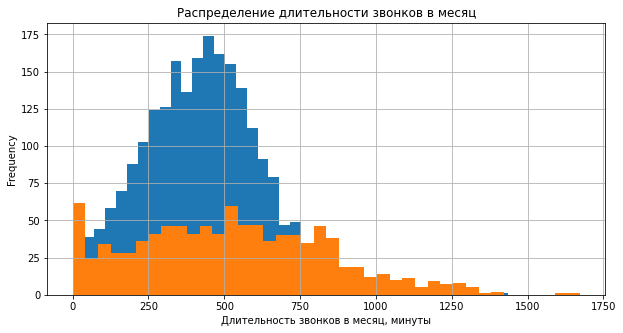

In [216]:
df_users_pivot[df_users_pivot['tariff_name'] == 'smart']['calls_duration']\
    .plot(kind='hist', bins=40, grid=True, figsize=(10, 5))\
    .set_title('Распределение длительности звонков в месяц')

df_users_pivot[df_users_pivot['tariff_name'] == 'ultra']['calls_duration']\
    .plot(kind='hist', bins=40, grid=True, figsize=(10, 5))

plt.xlabel("Длительность звонков в месяц, минуты")

Text(0.5, 0, 'Количество звонков в месяц')

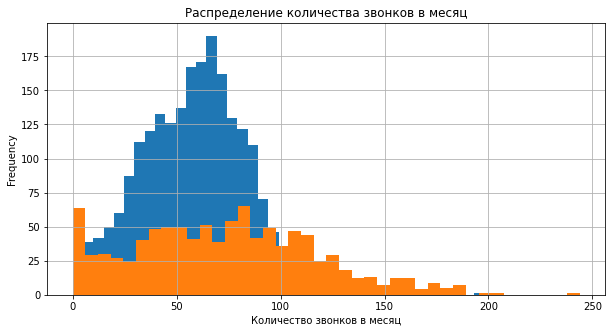

In [217]:
df_users_pivot[df_users_pivot['tariff_name'] == 'smart']['calls_quantity']\
    .plot(kind='hist', bins=40, grid=True, figsize=(10, 5))\
    .set_title('Распределение количества звонков в месяц')

df_users_pivot[df_users_pivot['tariff_name'] == 'ultra']['calls_quantity']\
    .plot(kind='hist', bins=40, grid=True, figsize=(10, 5))

plt.xlabel("Количество звонков в месяц")

Text(0.5, 0, 'Количество SMS в месяц')

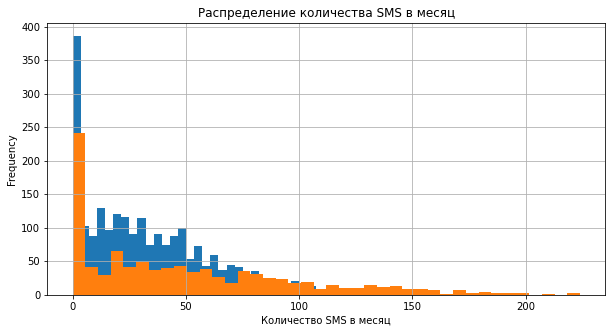

In [218]:
df_users_pivot[df_users_pivot['tariff_name'] == 'smart']['sms_quantity']\
    .plot(kind='hist', bins=40, grid=True, figsize=(10, 5))\
    .set_title('Распределение количества SMS в месяц')

df_users_pivot[df_users_pivot['tariff_name'] == 'ultra']['sms_quantity']\
    .plot(kind='hist', bins=40, grid=True, figsize=(10, 5))

plt.xlabel("Количество SMS в месяц")

Text(0.5, 0, 'Трафик в месяц, мегабайты')

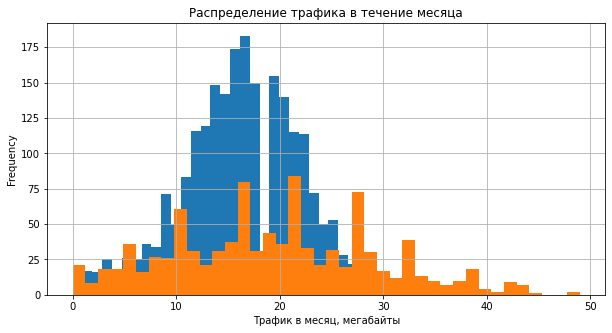

In [219]:
df_users_pivot[df_users_pivot['tariff_name'] == 'smart']['gb_used']\
    .plot(kind='hist', bins=40, grid=True, figsize=(10, 5))\
    .set_title('Распределение трафика в течение месяца')

df_users_pivot[df_users_pivot['tariff_name'] == 'ultra']['gb_used']\
    .plot(kind='hist', bins=40, grid=True, figsize=(10, 5))

plt.xlabel("Трафик в месяц, мегабайты")

Text(0.5, 0, 'Выручка в месяц, рубли')

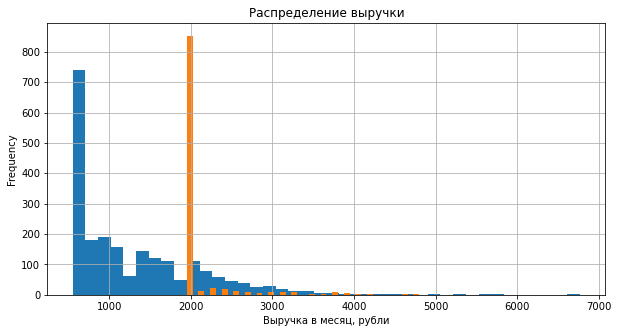

In [220]:
df_users_pivot[df_users_pivot['tariff_name'] == 'smart']['revenue']\
    .plot(kind='hist', bins=40, grid=True, figsize=(10, 5))\
    .set_title('Распределение выручки')

df_users_pivot[df_users_pivot['tariff_name'] == 'ultra']['revenue']\
    .plot(kind='hist', bins=40, grid=True, figsize=(10, 5))

plt.xlabel("Выручка в месяц, рубли")

**Построим** диаграммы размаха по звонкам, сообщениям, трафику и выручке по 2-м тарифам.

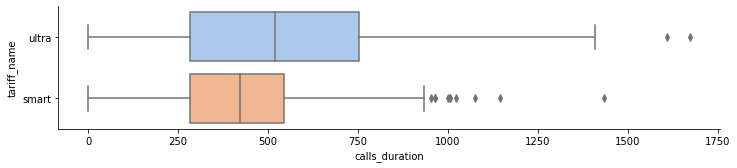

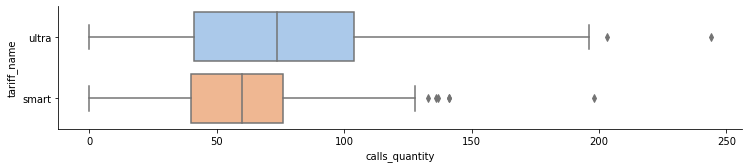

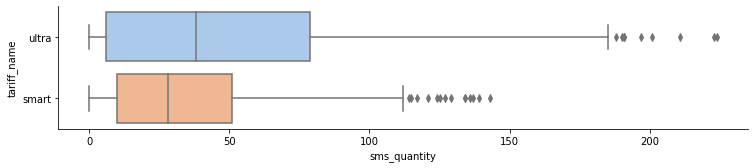

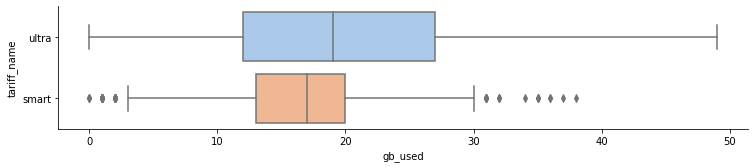

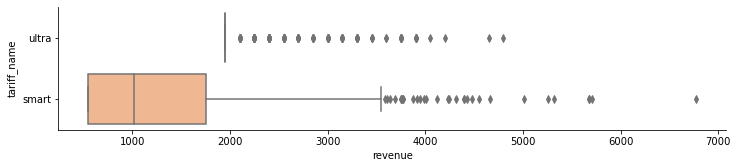

In [231]:
for column in ['calls_duration', 'calls_quantity', 'sms_quantity', 'gb_used', 
        'revenue']:    
    g = sns.catplot(y='tariff_name', x=column, kind="box", data= df_users_pivot, orient='h', palette = 'pastel')
    g.fig.set_figwidth(12)
    g.fig.set_figheight(2)


**Посчитаем** средние, стандартные отклонения и дисперсии у 2-х тарифов по звонкам, сообщениям, интернет-трафику и выручке.

In [222]:
df_smart_stat = df_users_pivot[df_users_pivot['tariff_name'] == 'smart']['calls_duration'].agg(['mean','std','var']).reset_index()

df_smart_stat_1 = df_users_pivot[df_users_pivot['tariff_name'] == 'smart']['sms_quantity'].agg(['mean','std','var']).reset_index()

df_smart_stat_2 = df_users_pivot[df_users_pivot['tariff_name'] == 'smart']['gb_used'].agg(['mean','std','var']).reset_index()

df_smart_stat_3 = df_users_pivot[df_users_pivot['tariff_name'] == 'smart']['revenue'].agg(['mean','std','var']).reset_index()


df_smart_stat = df_smart_stat.merge(df_smart_stat_1, on=['index'], how='outer')
df_smart_stat = df_smart_stat.merge(df_smart_stat_2, on=['index'], how='outer')
df_smart_stat = df_smart_stat.merge(df_smart_stat_3, on=['index'], how='outer')
df_smart_stat

,index,calls_duration,sms_quantity,gb_used,revenue
0,mean,417.747534,33.369058,16.321525,1289.641704
1,std,190.476754,28.230396,5.756167,818.370799
2,var,36281.393836,796.955256,33.133453,669730.763895


In [223]:
df_ultra_stat = df_users_pivot[df_users_pivot['tariff_name'] == 'ultra']['calls_duration'].agg(['mean','std','var']).reset_index()

df_ultra_stat_1 = df_users_pivot[df_users_pivot['tariff_name'] == 'ultra']['sms_quantity'].agg(['mean','std','var']).reset_index()

df_ultra_stat_2 = df_users_pivot[df_users_pivot['tariff_name'] == 'ultra']['gb_used'].agg(['mean','std','var']).reset_index()

df_ultra_stat_3 = df_users_pivot[df_users_pivot['tariff_name'] == 'ultra']['revenue'].agg(['mean','std','var']).reset_index()


df_ultra_stat = df_ultra_stat.merge(df_ultra_stat_1, on=['index'], how='outer')
df_ultra_stat = df_ultra_stat.merge(df_ultra_stat_2, on=['index'], how='outer')
df_ultra_stat = df_ultra_stat.merge(df_ultra_stat_3, on=['index'], how='outer')

df_ultra_stat

,index,calls_duration,sms_quantity,gb_used,revenue
0,mean,526.089249,49.313387,19.474645,2070.030426
1,std,317.887549,47.806040,9.868057,376.015578
2,var,101052.493549,2285.417425,97.378544,141387.714809


Посчитаем средние **выручки** пользователей.

In [224]:
df_users_revenue_mean = df_users_pivot.groupby(['user_id', 'tariff_name', 'city'])['revenue'].mean() 
df_users_revenue_mean = df_users_revenue_mean.reset_index()
df_users_revenue_mean = df_users_revenue_mean.rename(columns={'revenue':'revenue_user_mean'})
df_users_revenue_mean

,user_id,tariff_name,city,revenue_user_mean
0,1000,ultra,Краснодар,1950.000000
1,1001,smart,Москва,850.000000
2,1002,smart,Стерлитамак,1035.714286
3,1003,ultra,Москва,1950.000000
4,1004,ultra,Новокузнецк,1950.000000
...,...,...,...,...
495,1495,ultra,Иркутск,2310.000000
496,1496,smart,Вологда,2362.583333
497,1497,smart,Челябинск,928.333333
498,1498,smart,Владикавказ,1659.000000


**Выводы**:
- Среднее количество использованных **минут** в месяц у двух тарифов отличается, но не очень сильно. Причем, если пользователи "Смарта" в среднем укладываются в пакет бесплатных минут и близки к своему лимиту, то "Ультре" достаточно половины бесплатного тарифа. Учитывая разницу в стоимости тарифов, получается, что пользователи "Ультра" переплачивают за количество минут, покупая базовый тариф своей марки.
- Распределения **звонков** у тарифов отличаются - у "Смарта" близко к нормальному распределению, при этом скошено влево. У "Ультра" колокол более плоский, тоже скошен влево. У обоих тарифов большие выбросы вправо.
- Сравнение количества **сообщений** показывает, что "Ультра" отправляет в 1,5 больше сообщений, НО даже близко не приближается к границе своего тарифа в 1000 сообщений ("Смарт" как раз укладывается в границы бесплатного лимита.) Распределения сообщений в обоих случаях скошены влево, и у обоих тарифов есть большой хвост выбросов вправо.
- Если говорить об **интернет-трафике**, то средний трафик пользователей "Смарта" выходит за рамки бесплатного лимита, а, значит, генерирует **дополнительную** выручку. Пользователи "Ультры" тратят в интернете в среднем больше трафика (чем "Смарт"), но спокойно вписываются в свои лимиты. Т.е. в третий раз понятно, что юзеры переплачивают за тариф "Ультра", тк в среднем они не только не выходят за рамки лимита, но даже не приближаются к нему.
- Распределения **трафика** у обоих тарифов близки к нормальному с небольшой скошенностью влево. У "Ультра" колокол более плоский. У обоих тарифов есть пользователи, которые тратят много трафика (выбросы вправо). У "Смарта" на диаграмме размаха также видны пользователи, которые не очень активны в использовании интернета. 
- Если говорить о **распределениях** звонков, сообщений и трафика, то в этих случаях стандартные распределения **больше** у пользователей "Ультра". 
- Распределение **выручек** 2-х тарифов похожи друг на друга и демонстрируют экспоненциальность: ядро пользователей в левой части гистограммы или диаграммы и длинный хвост в правой части. Отличие в стандартном отклонении: у пользователей "Смарта" оно **больше**, чем у "Ультры" почти в 2 раза. Хотя медианы выручек тарифов отличаются больше, чем в 2 раза в пользу "Ультры", разброс значений у "Смарта" значительно шире. Результат - пользователи "Смарта" в сумме в год приносят на 870 т.р. в год **больше** пользователей "Ультра". 

## Проверка гипотез

Сформулируем гипотезы исследования.
1) H0: Средняя выручка пользователей тарифов "Смарт" и "Ультра" не различается. 

H1: Средняя выручка пользователей тарифов "Смарт" и "Ультра" различается.

2) H0: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

H1: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [225]:
alpha = .05

results = st.ttest_ind(
    df_users_pivot[df_users_pivot['tariff_name'] == 'smart']['revenue'], 
    df_users_pivot[df_users_pivot['tariff_name'] == 'ultra']['revenue'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 8.081909555489933e-161
Отвергаем нулевую гипотезу


In [226]:
df_users_pivot_non_moscow = df_users_pivot[df_users_pivot['city'] != 'Москва']
df_users_pivot_non_moscow = df_users_pivot_non_moscow.reset_index()
# df_users_pivot_non_moscow

In [227]:
df_users_pivot_moscow = df_users_pivot[df_users_pivot['city'] == 'Москва']
df_users_pivot_moscow = df_users_pivot_moscow.reset_index()
# df_users_pivot_moscow

In [228]:
alpha = .05

results = st.ttest_ind(
    df_users_pivot_moscow['revenue'], 
    df_users_pivot_non_moscow['revenue'], nan_policy='omit')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


Посмотрим на разброс выручки пользователей из Москвы и пользователей остальных городов

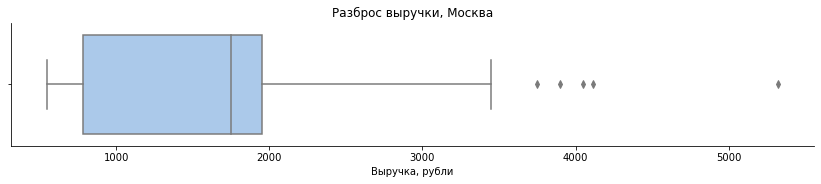

In [229]:
for column in ['revenue']:    
    g = sns.catplot(x=column, kind="box"\
                    , data= df_users_pivot_moscow\
                    , orient='h', palette = 'pastel')
    g.fig.set_figwidth(12)
    g.fig.set_figheight(2)

g.set(title = "Разброс выручки, Москва", xlabel = 'Выручка, рубли')

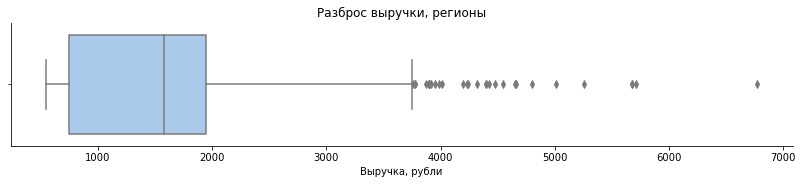

In [230]:
for column in ['revenue']:    
    g = sns.catplot(x=column, kind="box", data= df_users_pivot_non_moscow, orient='h', palette = 'pastel')
    g.fig.set_figwidth(12)
    g.fig.set_figheight(2)
    
g.set(title = "Разброс выручки, регионы", xlabel = 'Выручка, рубли')

**Выводы** из проверок гипотез:
- Выручки тарифов значимо отличаются друг от друга;
- Разницы в выручке между регионами нет;
- Диаграммы размаха выручек пользователей Москвы и регионов **очень похожи**, отличие в наличии бОльшего количество выбросов вправо у региональных пользователей. Т.е. часть региональных юзеров готовы тратить **больше** за услуги связи, но таких юзеров относительно немного.

После пересчета всех данных и нового сравнения средних по выручкам пользователей разных регионов мы получили p-значение: 0.5400751614511182. Это означает, что при верности утверждения "средние выручки Москвы и регионов не отличаются" вероятность попадания случайного значения из одной группы выручек на края "колокола" распределения другой группы выручек - 27%. Или если мы отклоним нулевую гипотезу, то мы ошибемся в 54% случаев. Хотя средний чек в Москве и регионах неодинаков, с вероятностью 54% такое или большее различие можно получить случайно Это явно **слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками**.

## Общий вывод

1) Тариф "Ультра" стимулирует пользователей больше говорить, чаще переписываться и больше пользоваться интернетом (либо этот тариф покупают юзеры, для которых цена не очень важна, а важна "широта" лимита.) 

2) При этом бесплатный лимит в некоторых случаях недостаточен для пользователей "Смарта" - если средние показатели в целом близки к границам тарифа, то некоторые пользователи "Смарта" доплачивают за использование интернета сверх лимита. 

3) Вариативность поведения пользователей "Ультры" намного выше, чем у пользователей "Смарта", за исключением показателей выручки. 

4) Выручки тарифов значимо отличаются друг от друга. С т.зр. годовой выручки оператору выгоднее тариф "Смарт". С т.зр. средней выручки на пользователя - тариф "Ультра" (из-за изначально высокой абонентской платы.) 

5) Часть пользователей тарифа "Смарт" тратят больше базовой суммы, а небольшая часть сравнима по расходам с пользователями "Ультры". Здесь есть потенциал для перетягивания части пользователей "Смарта" в "Ультру", либо для создания промежуточного тарифа. 

6) Также существует опасность ухода части пользователей "Смарта" к другому оператору из-за того, что "Смарт" по лимитам недостаточен, а тариф "Ультра" - слишком дорог.

7) Разницы в выручке между регионами нет. При этом часть региональных юзеров готовы тратить больше за услуги связи, но таких юзеров относительно немного. В случае подготовки рекламной кампании уже существующих или новых тарифов, структуру регионального потребления нужно изучить более детально.  

PS: 8) Ниже в анализе данных ревьюером виден рост количества пользователей "Смарта" (видимо, результат рекламной кампании, а также показатель предпочтения "Смарта" новыми пользователями), а также рост выручки у юзеров "Смарта", причем не только накопительной, но и индивидуальной. Действительно риск оттока части пользователей велик, а распределение оттока указывает на недовольство юзеров именно "Смарта". 